<h2>Big Data in Urban Mental Health - Coursework</h2>

<h4>Importing Libraries</h4>

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd

import libpysal as lps
from libpysal.weights import Queen
import pysal as ps

import esda
import spreg
from spreg import OLS
from spreg import ML_Error

import matplotlib.pyplot as plt
import statsmodels.stats.api as sms

<h4>Importing Data Sets</h4>

In [2]:
file_path = 'D:/KCL sm2/mental health/CUSP2021_project_random_subset_prob.csv'
df = pd.read_csv(file_path)

columns_drop = ['primary_diagnosis', 'gender_id', 'ethnicitycleaned', 'cleaneddateofbirth', 'closest_mmse_DENOMINATOR', 'marital_Status_id']
df.drop(columns=columns_drop, inplace=True)
df.head(5)

,index,Outomce_emegency_hosp_admin_after_index,Time_to_event_emergency_hosp_admin,No_of_emergency_hosp_admins,Total_days_in_all_admissions_after_index_Sum_LOS,Gender_code,Ethnicitycode,closest_mmse_NUMERATOR,LSOA11,Index of Multiple Deprivation Score,...,achei6m,memantine6m,asy,antichol,ad,hypnotics_anx,Failure_death_1_31032018,Age_diagnosis_round,diagnosis_date_ym,Time_to_event_death_round
0,0,1,0.076660,3,0,0,0,12,E01003097,39.45,...,0,0,0,0,0,0,1,78,2017-05,1.6
1,1,0,0.142368,7,20,1,0,.,E01003021,38.93,...,0,0,1,0,1,0,0,84,2009-06,6.9
2,2,1,0.446270,4,0,0,0,22,E01001064,21.1,...,0,0,0,0,0,0,1,81,2012-07,3.9
3,3,0,0.010951,11,105,1,0,15,E01003221,31.18,...,0,0,0,0,0,0,1,85,2015-01,4.7
4,4,1,0.317591,0,15,1,.,11,E01004023,52.01,...,0,0,0,0,0,0,0,77,2011-11,7.9


In [3]:
file_path = 'D:/KCL sm2/mental health/census2018.csv'
df_census = pd.read_csv(file_path)
# delete rows with NaN in 'LSOA' column
df_census = df_census.dropna(subset=['LSOA'])
# delete the second column
df_census = df_census.drop(df_census.columns[1], axis=1)

df_census['All Ages'] = df_census['All Ages'].str.replace(',', '').astype(int)
df_census.iloc[:, 4:94] = df_census.iloc[:, 4:94].apply(pd.to_numeric, errors='coerce')
df_census['elder_65+'] = df_census.iloc[:, 69:94].sum(axis=1)
df_census['elder_ratio'] = df_census['elder_65+'] / df_census['All Ages']
df_census.head(5)

C:\Users\kayla\AppData\Local\Temp\ipykernel_17948\3022061862.py:2: DtypeWarning: Columns (91,92,93) have mixed types. Specify dtype option on import or set low_memory=False.
  df_census = pd.read_csv(file_path)


,Area Codes,LSOA,All Ages,0,1,2,3,4,5,6,...,83,84,85,86,87,88,89,90+,elder_65+,elder_ratio
1,E01020634,County Durham 001A,1665,22,12,14,16,17,22,19,...,5,11,4,8,3,3,7,9,359,0.215616
2,E01020635,County Durham 001B,1364,19,13,13,27,11,17,11,...,7,3,8,5,6,5,7,8,293,0.214809
3,E01020636,County Durham 001C,1730,18,21,10,22,20,19,27,...,13,6,5,9,4,3,3,15,326,0.188439
4,E01020654,County Durham 001D,1830,11,13,20,16,21,15,21,...,9,8,10,17,10,11,10,37,382,0.208743
5,E01020676,County Durham 001E,1510,17,9,11,16,17,16,17,...,2,3,6,3,4,3,0,2,301,0.199338


In [4]:
lsoa_shapefile_path = 'D:/KCL sm2/mental health/data/LDN-LSOAs.shp'
gdf_lsoa = gpd.read_file(lsoa_shapefile_path)
gdf_lsoa.to_crs(epsg=27700, inplace=True)

# calcute the areas of LSOAs
gdf_lsoa['area'] = gdf_lsoa.geometry.area

# set the unit of the area to be square kilometers
gdf_lsoa['area'] = gdf_lsoa['area'] / 10**6

gdf_lsoa.head(5)


,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,geometry,area
0,E01000001,City of London 001A,City of London 001A,1,133320.768872,2291.846072,"POLYGON ((532105.330 182017.386, 532162.728 18...",0.133320
1,E01000002,City of London 001B,City of London 001B,2,226191.272990,2433.960112,"POLYGON ((532747.048 181793.042, 532671.921 18...",0.226190
2,E01000003,City of London 001C,City of London 001C,3,57302.966538,1142.359799,"POLYGON ((532135.385 182204.275, 532158.489 18...",0.057303
3,E01000005,City of London 001E,City of London 001E,4,190738.760504,2167.868343,"POLYGON ((533808.170 180773.910, 533649.287 18...",0.190737
4,E01000006,Barking and Dagenham 016A,Barking and Dagenham 016A,5,144195.846857,1935.510354,"POLYGON ((545122.084 184321.013, 545271.951 18...",0.144191


In [5]:
gdf_lsoa.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.01, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<h4>Data Cleaning</h4>

In [6]:
merged_gdf = pd.merge(gdf_lsoa, df_census[['Area Codes', 'All Ages', 'elder_ratio']], left_on='lsoa11cd', right_on='Area Codes', how='left')

merged_gdf.drop(columns='Area Codes', inplace=True)
merged_gdf.head(3)

,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,geometry,area,All Ages,elder_ratio
0,E01000001,City of London 001A,City of London 001A,1,133320.768872,2291.846072,"POLYGON ((532105.330 182017.386, 532162.728 18...",0.133320,1480,0.252703
1,E01000002,City of London 001B,City of London 001B,2,226191.272990,2433.960112,"POLYGON ((532747.048 181793.042, 532671.921 18...",0.226190,1451,0.24328
2,E01000003,City of London 001C,City of London 001C,3,57302.966538,1142.359799,"POLYGON ((532135.385 182204.275, 532158.489 18...",0.057303,1612,0.229529


In [7]:
# calculate the population density of LSOAs
merged_gdf['population_density'] = round(merged_gdf['All Ages'] / merged_gdf['area'], 2)
merged_gdf.head(3)

,lsoa11cd,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,geometry,area,All Ages,elder_ratio,population_density
0,E01000001,City of London 001A,City of London 001A,1,133320.768872,2291.846072,"POLYGON ((532105.330 182017.386, 532162.728 18...",0.133320,1480,0.252703,11101.08
1,E01000002,City of London 001B,City of London 001B,2,226191.272990,2433.960112,"POLYGON ((532747.048 181793.042, 532671.921 18...",0.226190,1451,0.24328,6414.96
2,E01000003,City of London 001C,City of London 001C,3,57302.966538,1142.359799,"POLYGON ((532135.385 182204.275, 532158.489 18...",0.057303,1612,0.229529,28131.29


In [8]:
# merge the mental health data with the census data
gdf = pd.merge(df, merged_gdf, left_on='LSOA11', right_on='lsoa11cd', how='left')
gdf.head(3)


,index,Outomce_emegency_hosp_admin_after_index,Time_to_event_emergency_hosp_admin,No_of_emergency_hosp_admins,Total_days_in_all_admissions_after_index_Sum_LOS,Gender_code,Ethnicitycode,closest_mmse_NUMERATOR,LSOA11,Index of Multiple Deprivation Score,...,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,geometry,area,All Ages,elder_ratio,population_density
0,0,1,0.076660,3,0,0,0,12,E01003097,39.45,...,Lambeth 006A,Lambeth 006A,3031.0,9.894443e+04,1991.518005,"POLYGON ((530212.224 177438.915, 530259.697 17...",0.098943,1682.0,0.118312,16999.66
1,1,0,0.142368,7,20,1,0,.,E01003021,38.93,...,Lambeth 021A,Lambeth 021A,2955.0,1.617879e+05,2405.106607,"POLYGON ((530698.200 174566.910, 530688.676 17...",0.161785,2472.0,0.09466,15279.50
2,2,1,0.446270,4,0,0,0,22,E01001064,21.1,...,Croydon 026C,Croydon 026C,1046.0,3.473748e+06,10678.314161,"POLYGON ((536084.863 165027.932, 536131.762 16...",3.473624,1608.0,0.263682,462.92


In [9]:
# find the NaN values in the 'population_density' column
gdf['population_density'] = pd.to_numeric(gdf['population_density'], errors='coerce')
gdf[gdf['population_density'].isnull()]

,index,Outomce_emegency_hosp_admin_after_index,Time_to_event_emergency_hosp_admin,No_of_emergency_hosp_admins,Total_days_in_all_admissions_after_index_Sum_LOS,Gender_code,Ethnicitycode,closest_mmse_NUMERATOR,LSOA11,Index of Multiple Deprivation Score,...,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,geometry,area,All Ages,elder_ratio,population_density
142,142,0,0.125941,0,3,0,0,24,.,14.88,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
193,193,1,0.114990,6,0,1,0,.,.,36.4,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
260,260,1,0.427105,4,0,1,0,.,.,32.28,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
291,291,0,0.254620,1,14,1,0,13,.,29.75,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
323,323,1,0.030116,3,0,1,0,.,.,25.97,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14519,14519,1,0.372348,2,0,1,0,19,.,9.24,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
14585,14585,1,0.043806,6,0,1,0,27,.,20.43,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
14615,14615,1,0.528405,5,30,0,0,13,.,33.22,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
14646,14646,1,0.355921,0,0,1,1,11,.,9.24,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN


In [10]:
# find the NaN values in the columns
gdf['closest_mmse_NUMERATOR'] = pd.to_numeric(gdf['closest_mmse_NUMERATOR'], errors='coerce')
gdf['Gender_code'] = pd.to_numeric(gdf['Gender_code'], errors='coerce')
gdf['Age_diagnosis_round'] = pd.to_numeric(gdf['Age_diagnosis_round'], errors='coerce')
gdf[gdf['closest_mmse_NUMERATOR'].isnull()]

,index,Outomce_emegency_hosp_admin_after_index,Time_to_event_emergency_hosp_admin,No_of_emergency_hosp_admins,Total_days_in_all_admissions_after_index_Sum_LOS,Gender_code,Ethnicitycode,closest_mmse_NUMERATOR,LSOA11,Index of Multiple Deprivation Score,...,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,geometry,area,All Ages,elder_ratio,population_density
1,1,0,0.142368,7,20,1,0,NaN,E01003021,38.93,...,Lambeth 021A,Lambeth 021A,2955.0,1.617879e+05,2405.106607,"POLYGON ((530698.200 174566.910, 530688.676 17...",0.161785,2472.0,0.09466,15279.50
9,9,0,0.216290,3,49,1,0,NaN,E01003958,18.07,...,Southwark 032D,Southwark 032D,3870.0,1.621119e+05,1784.667750,"POLYGON ((534133.668 174258.417, 534139.940 17...",0.162109,1806.0,0.08804,11140.66
19,19,1,0.298426,0,5,1,0,NaN,E01001094,32.01,...,Croydon 038E,Croydon 038E,1076.0,1.171380e+06,5970.514885,"POLYGON ((530518.135 162570.983, 530551.826 16...",1.171380,1543.0,0.240441,1317.25
20,20,0,0.139630,1,5,0,1,NaN,E01003144,37.97,...,Lambeth 034C,Lambeth 034C,3077.0,5.056453e+05,4774.951288,"POLYGON ((531317.302 171053.057, 531136.300 17...",0.505631,1526.0,0.158585,3018.01
21,21,1,0.114990,2,0,0,0,NaN,E01003309,9.32,...,Lewisham 027A,Lewisham 027A,3236.0,1.598314e+05,2303.376175,"POLYGON ((535680.148 172660.169, 535834.106 17...",0.159828,1553.0,0.110109,9716.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14974,14974,1,0.104038,1,0,0,0,NaN,E01001022,33.45,...,Croydon 044E,Croydon 044E,1004.0,9.887599e+05,5358.097790,"POLYGON ((531812.427 157706.209, 531876.045 15...",0.988731,1449.0,0.289855,1465.51
14983,14983,1,0.101300,4,0,0,0,NaN,E01001109,34.09,...,Croydon 013B,Croydon 013B,1091.0,4.750837e+05,3508.661702,"POLYGON ((533064.041 166601.503, 532978.254 16...",0.475069,2152.0,0.177974,4529.87
14989,14989,0,0.199863,3,10,1,0,NaN,E01003957,44.65,...,Southwark 032C,Southwark 032C,3869.0,1.684475e+05,2167.002488,"POLYGON ((534535.471 174258.747, 534417.555 17...",0.168444,1820.0,0.095055,10804.76
14990,14990,0,0.005476,1,4,1,1,NaN,E01001019,24.29,...,Croydon 044B,Croydon 044B,1001.0,5.929952e+05,5230.135620,"POLYGON ((530587.660 158911.679, 530601.045 15...",0.592980,1527.0,0.230517,2575.13


In [11]:
# find the NaN values in the 'Ethnicitycode' column
gdf['Ethnicitycode'] = pd.to_numeric(gdf['Ethnicitycode'], errors='coerce')
gdf[gdf['Ethnicitycode'].isnull()]

,index,Outomce_emegency_hosp_admin_after_index,Time_to_event_emergency_hosp_admin,No_of_emergency_hosp_admins,Total_days_in_all_admissions_after_index_Sum_LOS,Gender_code,Ethnicitycode,closest_mmse_NUMERATOR,LSOA11,Index of Multiple Deprivation Score,...,lsoa11nm,lsoa11nmw,objectid,st_areasha,st_lengths,geometry,area,All Ages,elder_ratio,population_density
4,4,1,0.317591,0,15,1,NaN,11.0,E01004023,52.01,...,Southwark 004D,Southwark 004D,3928.0,113520.561118,1913.324648,"POLYGON ((534419.495 179767.867, 534487.741 17...",0.113519,1903.0,0.097215,16763.69
72,72,0,0.019165,6,24,1,NaN,18.0,E01003295,.,...,Lewisham 017D,Lewisham 017D,3223.0,182794.269781,3015.077037,"POLYGON ((538987.031 174441.190, 539218.317 17...",0.182790,1827.0,0.088123,9995.09
215,215,0,0.158795,0,0,0,NaN,15.0,E01003925,32.8,...,Southwark 020E,Southwark 020E,3840.0,87649.703638,1307.890440,"POLYGON ((532890.224 177233.159, 532864.327 17...",0.087649,1857.0,0.078083,21186.88
341,341,1,0.150582,0,0,0,NaN,19.0,E01003203,29.82,...,Lewisham 009D,Lewisham 009D,3136.0,145229.411518,2068.860083,"POLYGON ((539425.281 175533.304, 539466.241 17...",0.145226,2003.0,0.090864,13792.33
386,386,1,0.112252,1,0,0,NaN,27.0,E01001102,38.1,...,Croydon 035C,Croydon 035C,1084.0,646287.331918,5618.018579,"POLYGON ((534351.738 161469.567, 534350.362 16...",0.646261,1556.0,0.284704,2407.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14731,14731,0,0.060233,1,0,0,NaN,NaN,E01003961,24.7,...,Southwark 012B,Southwark 012B,3872.0,121432.729412,2274.177564,"POLYGON ((533036.211 178791.156, 533148.190 17...",0.121432,2145.0,0.129604,17664.25
14836,14836,0,0.010951,0,0,1,NaN,24.0,.,31.34,...,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN
14921,14921,1,0.010951,3,0,0,NaN,11.0,E01003029,20.7,...,Lambeth 017A,Lambeth 017A,2963.0,148805.637822,1965.759504,"POLYGON ((530087.568 174874.182, 530071.877 17...",0.148803,1923.0,0.065523,12923.10
14941,14941,0,0.041068,3,0,1,NaN,22.0,E01001084,43.05,...,Croydon 002A,Croydon 002A,1066.0,596706.396580,3704.145447,"POLYGON ((531768.674 170461.227, 531788.549 17...",0.596686,1916.0,0.16858,3211.07


In [12]:
# drop the rows with NaN values
gdf = gdf.dropna(subset=['population_density', 'closest_mmse_NUMERATOR', 'Ethnicitycode'])

In [13]:
# cleaned data
gdf = gpd.GeoDataFrame(gdf)
len(gdf)

10970

<h4>EDA</h4>

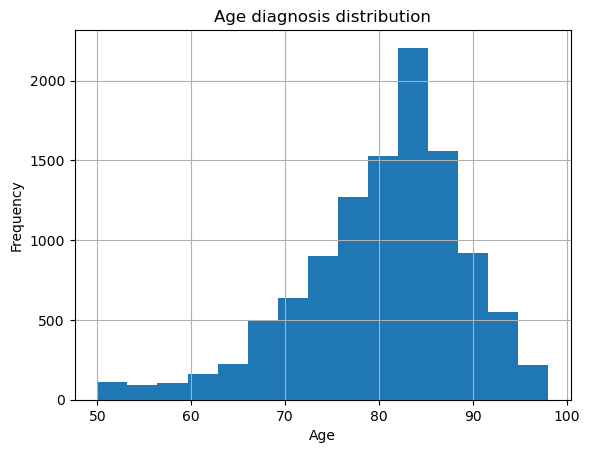

In [14]:
# age diagnosis distribution
plt.hist(gdf['Age_diagnosis_round'], bins=15)
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Age diagnosis distribution')
plt.grid(True)
plt.show()

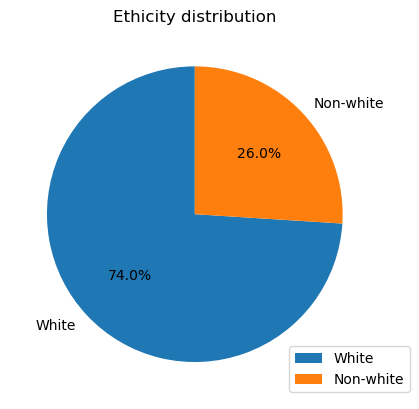

In [15]:
# ethinicity distribution (pie chart)
ethicity_counts = gdf['Ethnicitycode'].value_counts()

labels = ['White', 'Non-white']

plt.pie(ethicity_counts, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Ethicity distribution')
plt.legend(bbox_to_anchor=(1.1, 0), loc='lower right')
plt.show()

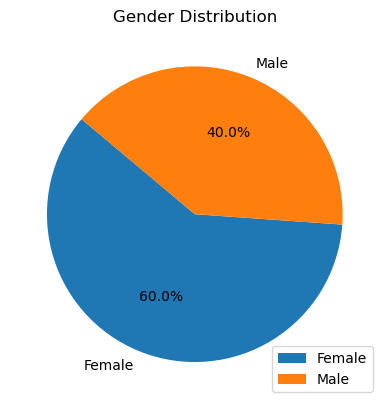

In [16]:
# Gender distribution (pie chart)
gender_counts = gdf['Gender_code'].value_counts()

labels = ['Female', 'Male']

plt.pie(gender_counts, labels=labels, autopct='%1.1f%%', startangle=140)
plt.title('Gender Distribution')
plt.legend(loc='lower right')
plt.show()

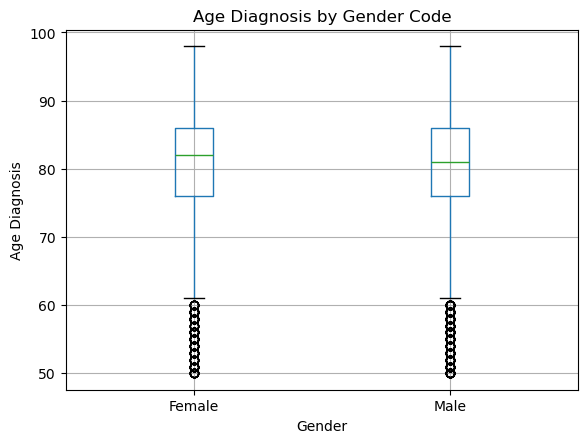

In [17]:
# Gender distribution by Age Diagnosis (boxplot)
labels = {0: 'Female', 1: 'Male'}

gdf.boxplot(column='Age_diagnosis_round', by='Gender_code')

ticks, _ = plt.xticks()

plt.xticks(ticks, [labels[int(i.get_text())] for i in plt.xticks()[1]])

plt.suptitle('')
plt.title('Age Diagnosis by Gender Code')
plt.xlabel('Gender')
plt.ylabel('Age Diagnosis')

plt.show()

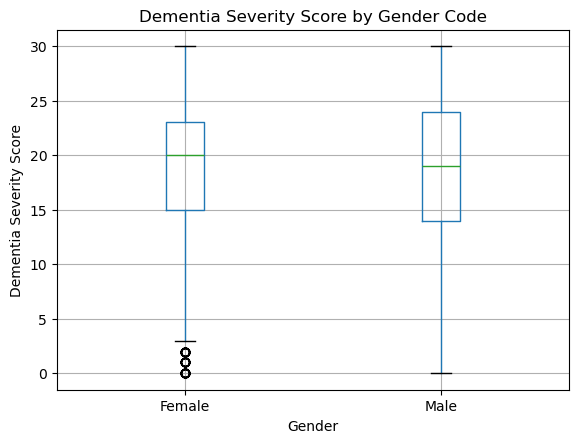

In [18]:
# Gender distribution by Dementia Severity Score (boxplot)
labels = {0: 'Female', 1: 'Male'}

gdf.boxplot(column='closest_mmse_NUMERATOR', by='Gender_code')

ticks, _ = plt.xticks()

plt.xticks(ticks, [labels[int(i.get_text())] for i in plt.xticks()[1]])

plt.suptitle('')
plt.title('Dementia Severity Score by Gender Code')
plt.xlabel('Gender')
plt.ylabel('Dementia Severity Score')

plt.show()

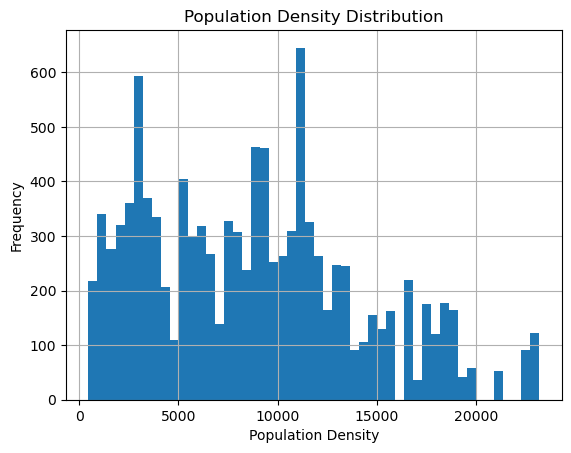

In [19]:
# population density distribution
plt.hist(gdf['population_density'], bins=50)
plt.xlabel('Population Density')
plt.ylabel('Frequency')
plt.title('Population Density Distribution')
plt.grid(True)
plt.show()

d:\Anaconda\envs\mscui2023\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


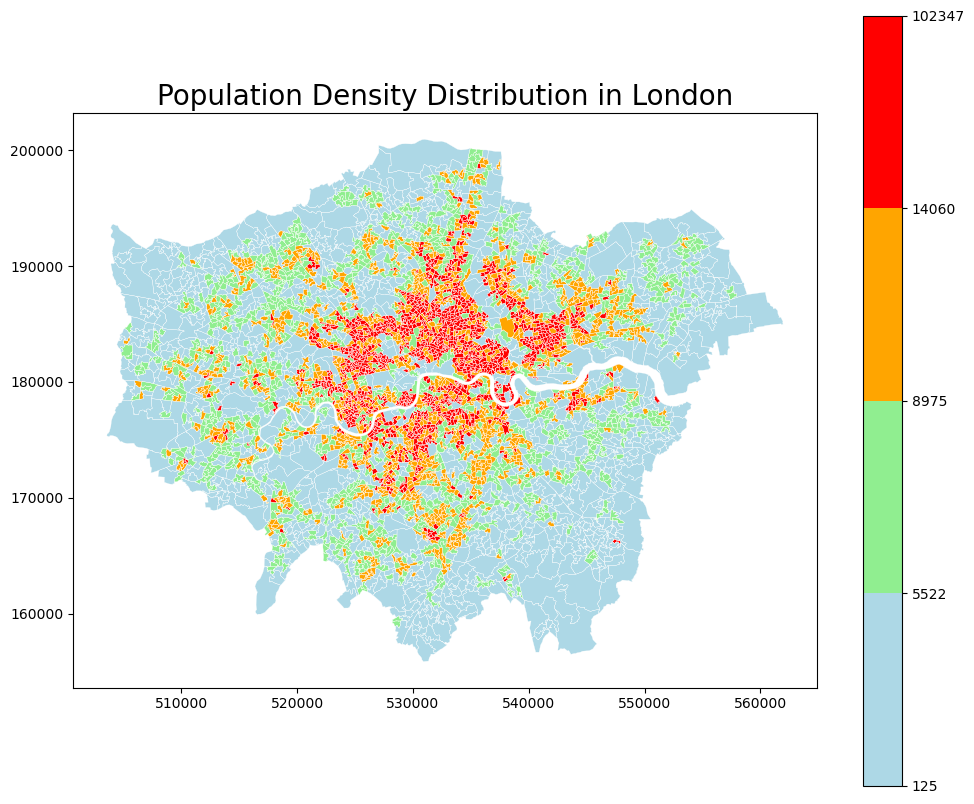

In [20]:
# population density distribution
# gdf_lsoa as the base map
import matplotlib.colors as mcolors

# use quantiles to divide the population density into 4 groups
quantiles = merged_gdf['population_density'].quantile([0, 0.25, 0.5, 0.75, 1.0])

# create the mapping between the population density and the colors
colors = ['lightblue', 'lightgreen', 'orange', 'red']
cmap = mcolors.ListedColormap(colors)
bounds = [quantiles[0], quantiles[0.25], quantiles[0.5], quantiles[0.75], quantiles[1]]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

fig, ax = plt.subplots(1, 1, figsize=(12, 10))
gdf_lsoa.boundary.plot(ax=ax, edgecolor='white', linewidth=0.2) 
merged_gdf.plot(column='population_density', ax=ax, legend=True, cmap=cmap, norm=norm)

plt.title('Population Density Distribution in London', fontsize=20)
plt.show()

d:\Anaconda\envs\mscui2023\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


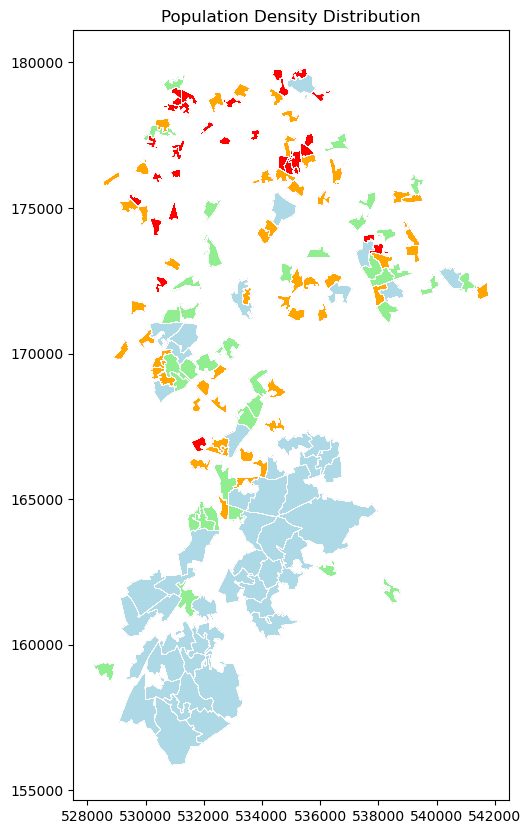

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(6, 10))
gdf.boundary.plot(ax=ax, edgecolor='white', linewidth=0.2) 
gdf.plot(column='population_density', ax=ax, cmap=cmap, norm=norm)
ax.grid(False)
plt.title('Population Density Distribution')
plt.show()

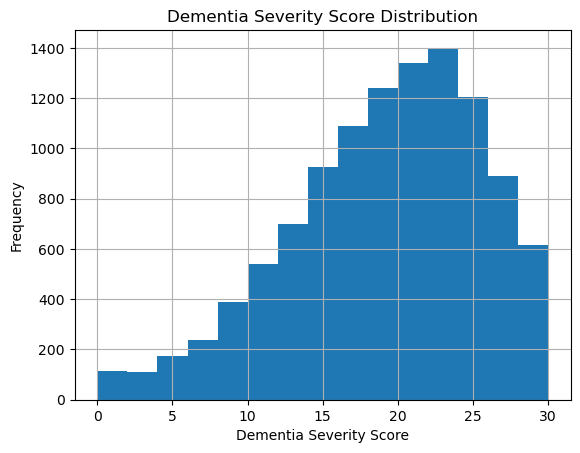

In [22]:
# dementia severity score distribution
plt.hist(gdf['closest_mmse_NUMERATOR'], bins=15)
plt.xlabel('Dementia Severity Score')
plt.ylabel('Frequency')
plt.title('Dementia Severity Score Distribution')
plt.grid(True)
plt.show()

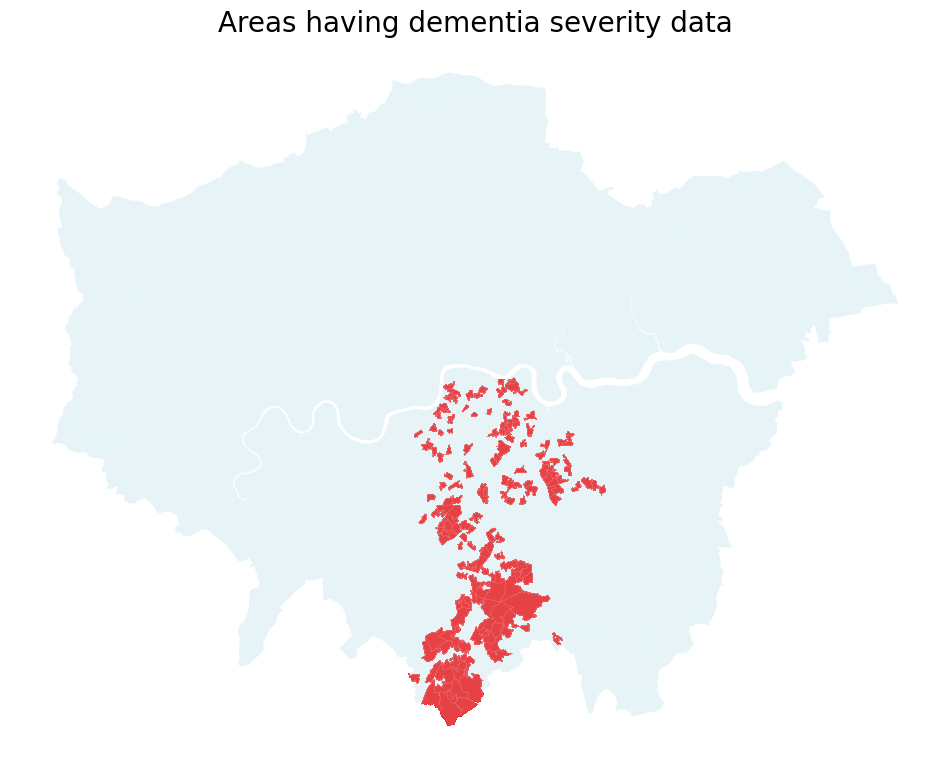

In [23]:
# find the area having dementia severity score
fig, ax = plt.subplots(1, 1, figsize=(12, 10)) 

matched_entities = gdf[gdf['LSOA11'].isin(gdf_lsoa['lsoa11cd'])]
matched_entities.plot(ax=ax, color='red', marker='o', markersize=5, alpha=1)
gdf_lsoa.boundary.plot(ax=ax, edgecolor='white', linewidth=0.2, facecolor='lightblue', alpha=0.3)

plt.title('Areas having dementia severity data', fontsize=20)
plt.axis('off')
plt.show()

d:\Anaconda\envs\mscui2023\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
d:\Anaconda\envs\mscui2023\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


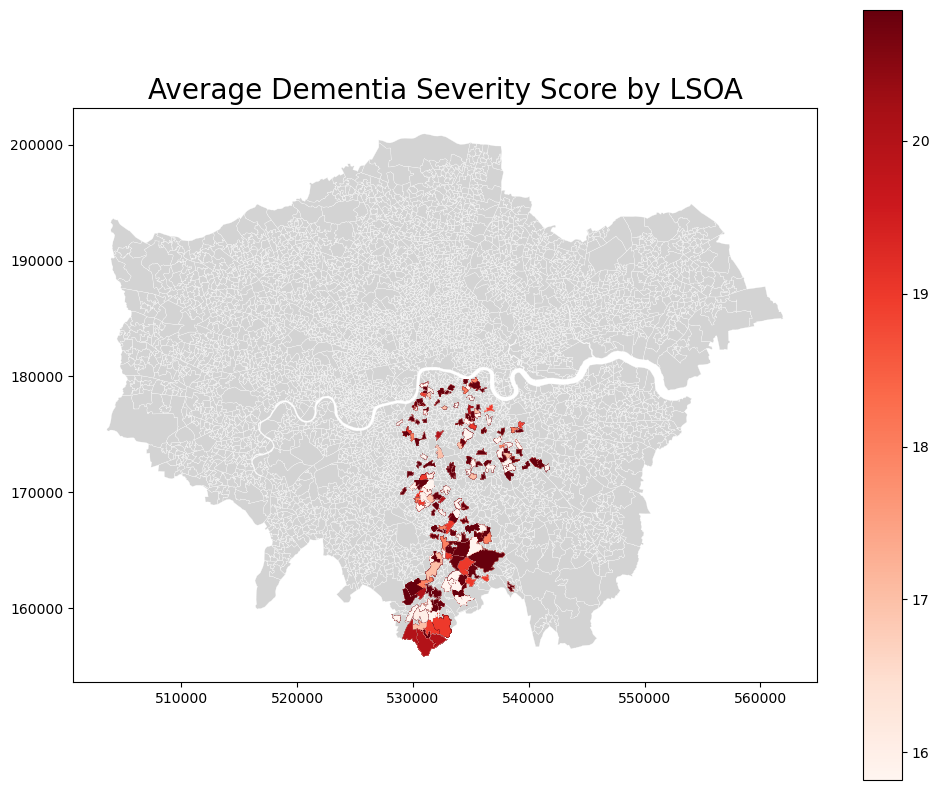

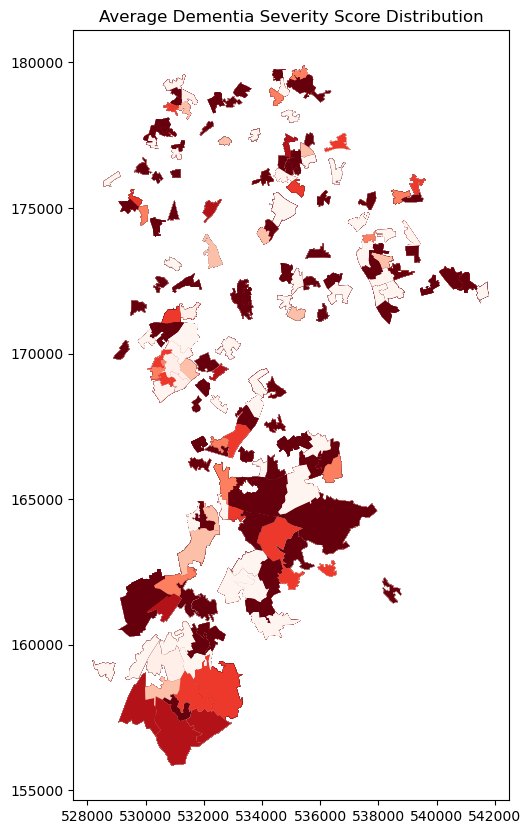

In [24]:
# dementia severity distribution
average_closest_mmse_lsoa = gdf.groupby('LSOA11')['closest_mmse_NUMERATOR'].mean()
gdf_merged = gdf.merge(average_closest_mmse_lsoa, on='LSOA11', suffixes=('', '_mean'))

vmin, vmax = np.min(average_closest_mmse_lsoa), np.max(average_closest_mmse_lsoa)
# norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
ax = gdf_lsoa.plot(figsize=(12, 10), color='lightgrey', edgecolor='white', linewidth=0.2)
gdf_merged.plot(ax=ax, column='closest_mmse_NUMERATOR', cmap='Reds', vmin=vmin, vmax=vmax, legend=True)
plt.title('Average Dementia Severity Score by LSOA', fontsize=20)

ax = gdf.plot(column='closest_mmse_NUMERATOR', figsize=(8, 10), cmap='Reds', vmin=vmin, vmax=vmax)
ax.set_title('Average Dementia Severity Score Distribution')
plt.show()


In [25]:
# categorize the dementia severity score
# >19 mild dementia, 10-19 moderate dementia, <10 severe dementia
gdf['dementia_severity'] = pd.cut(gdf['closest_mmse_NUMERATOR'], bins=[0, 10, 19, 30], labels=['severe', 'moderate', 'mild'])
gdf.head(3)

,index,Outomce_emegency_hosp_admin_after_index,Time_to_event_emergency_hosp_admin,No_of_emergency_hosp_admins,Total_days_in_all_admissions_after_index_Sum_LOS,Gender_code,Ethnicitycode,closest_mmse_NUMERATOR,LSOA11,Index of Multiple Deprivation Score,...,lsoa11nmw,objectid,st_areasha,st_lengths,geometry,area,All Ages,elder_ratio,population_density,dementia_severity
0,0,1,0.076660,3,0,0,0.0,12.0,E01003097,39.45,...,Lambeth 006A,3031.0,9.894443e+04,1991.518005,"POLYGON ((530212.224 177438.915, 530259.697 17...",0.098943,1682.0,0.118312,16999.66,moderate
2,2,1,0.446270,4,0,0,0.0,22.0,E01001064,21.1,...,Croydon 026C,1046.0,3.473748e+06,10678.314161,"POLYGON ((536084.863 165027.932, 536131.762 16...",3.473624,1608.0,0.263682,462.92,mild
3,3,0,0.010951,11,105,1,0.0,15.0,E01003221,31.18,...,Lewisham 025C,3153.0,3.303316e+05,3000.366576,"POLYGON ((538080.687 173007.376, 538117.937 17...",0.330324,2088.0,0.113985,6321.07,moderate


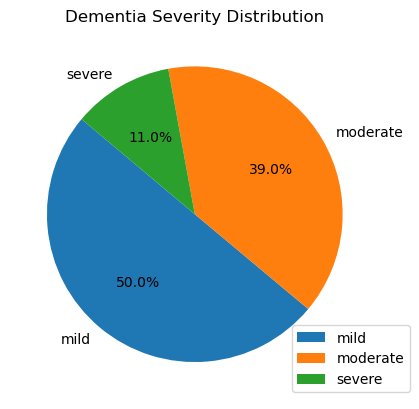

In [26]:
# dementia severity distribution (pie chart)
dementia_severity_counts = gdf['dementia_severity'].value_counts()

plt.figure()
plt.pie(dementia_severity_counts, labels=dementia_severity_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Dementia Severity Distribution')
plt.legend(bbox_to_anchor=(1.1, 0), loc='lower right')
plt.show()

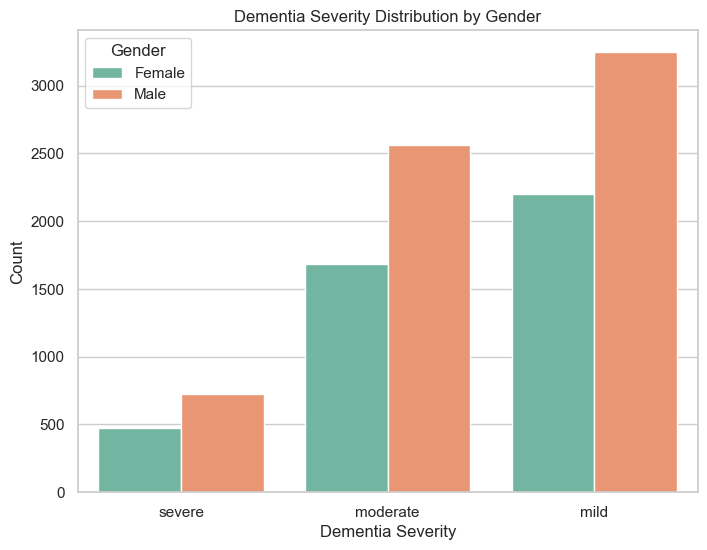

In [27]:
# dementia severity distribution by gender (countplot)
import seaborn as sns

sns.set(style="whitegrid")

plt.figure(figsize=(8, 6))
ax = sns.countplot(data=gdf, x='dementia_severity', hue='Gender_code', palette='Set2',
                   hue_order=[0, 1])

plt.title('Dementia Severity Distribution by Gender')
plt.xlabel('Dementia Severity')
plt.ylabel('Count')

handles, labels = ax.get_legend_handles_labels()
new_labels = ['Female', 'Male']
plt.legend(handles, new_labels, title='Gender', loc='upper left')

plt.show()

C:\Users\kayla\AppData\Local\Temp\ipykernel_17948\2940282120.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  gender_counts = gdf.groupby(['dementia_severity', 'Gender_code']).size().unstack()


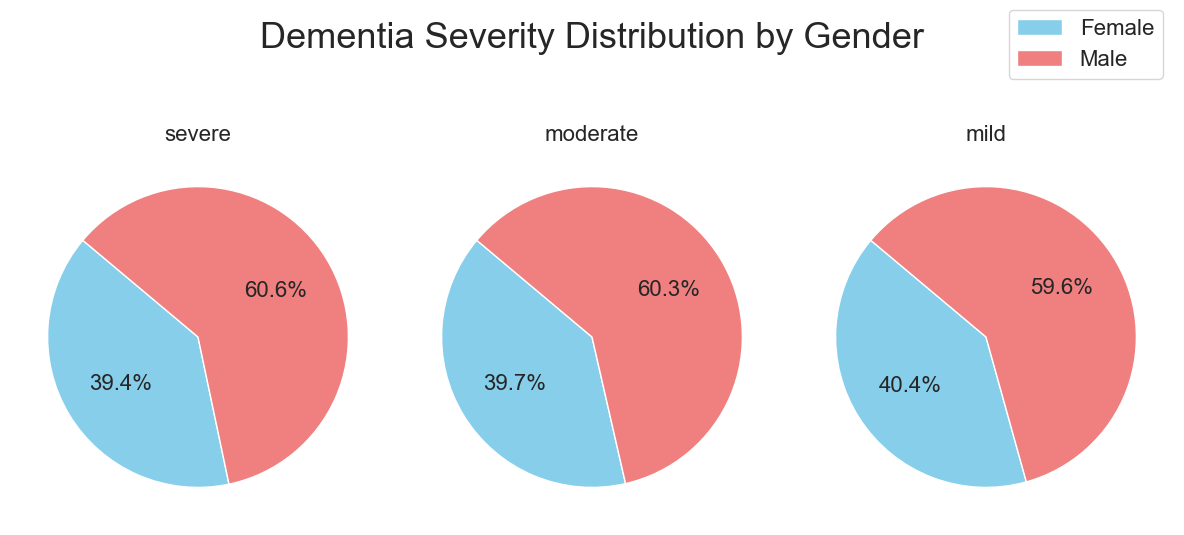

In [28]:
# dementia severity distribution by gender (pie chart)
gender_counts = gdf.groupby(['dementia_severity', 'Gender_code']).size().unstack()

severity_labels = gender_counts.index
colors = ['skyblue', 'lightcoral']
fig, axs = plt.subplots(1, len(severity_labels), figsize=(12, 6))

for i, severity in enumerate(severity_labels):
    ax = axs[i]
    # gender_counts.loc[severity].plot(kind='pie', colors=colors, autopct='%1.1f%%', startangle=140, ax=ax)
    # ax.set_title(severity)
    # ax.set_ylabel('')
    wedges, texts, autotexts = ax.pie(gender_counts.loc[severity], colors=colors, startangle=140, autopct='%1.1f%%')
    ax.set_title(severity, fontsize=16)
    
    for text in texts + autotexts:
        text.set_fontsize(16)


plt.legend(['Female', 'Male'], bbox_to_anchor=(1, 1.4), loc='upper right', fontsize=16)
plt.suptitle('Dementia Severity Distribution by Gender', fontsize=26)
plt.tight_layout()
plt.show()

C:\Users\kayla\AppData\Local\Temp\ipykernel_17948\2694661137.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=gdf, x='dementia_severity', y='population_density', palette='Set2')


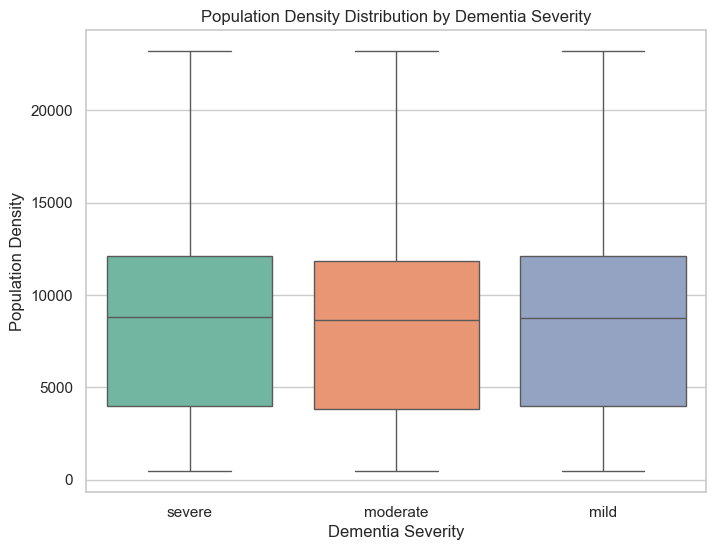

In [29]:
# population density distribution by dementia severity (boxplot)
plt.figure(figsize=(8, 6))
sns.boxplot(data=gdf, x='dementia_severity', y='population_density', palette='Set2')
plt.title('Population Density Distribution by Dementia Severity')
plt.xlabel('Dementia Severity')
plt.ylabel('Population Density')
plt.show()

In [30]:
# pearson correlation coefficient
from scipy.stats import pearsonr
corr_coefficient, p_value = pearsonr(gdf['population_density'], gdf['closest_mmse_NUMERATOR'])
print(f"Pearson Correlation Coefficient: {corr_coefficient}, P-value: {p_value}")

Pearson Correlation Coefficient: 0.0044752100067650775, P-value: 0.6393037889381619


In [31]:
gdf['elder_ratio'] = pd.to_numeric(gdf['elder_ratio'], errors='coerce')

corr_coefficient, p_value = pearsonr(gdf['elder_ratio'], gdf['closest_mmse_NUMERATOR'])
print(f"Pearson Correlation Coefficient: {corr_coefficient}, P-value: {p_value}")

Pearson Correlation Coefficient: 0.003776724794917374, P-value: 0.6924576452271323


Check spatial autocorrelation

In [32]:
# spatial autocorrelation
y = gdf['closest_mmse_NUMERATOR']
w_queen = Queen.from_dataframe(gdf)

mi = esda.Moran(y, w_queen)

print("The Statistic Moran's I is: "+str("%.4f"%mi.I),
      "\nThe Expected Value for Statistic I is: "+str("%.4f"%mi.EI),
      "\nThe Significance Test Value is: "+str("%.4f"%mi.p_norm))


C:\Users\kayla\AppData\Local\Temp\ipykernel_17948\2095437723.py:3: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w_queen = Queen.from_dataframe(gdf)


d:\Anaconda\envs\mscui2023\lib\site-packages\libpysal\weights\weights.py:224: UserWarning: The weights matrix is not fully connected: 
 There are 62 disconnected components.
  warnings.warn(message)


The Statistic Moran's I is: 0.0007 
The Expected Value for Statistic I is: -0.0001 
The Significance Test Value is: 0.5159


The value of Moran's I is close to 0 and the p-value greater than 0.05. This indicates that the dependent variable has no spatial autocorrelation.

<h4>Regression</h4>

Linear Regression - treat dependent variable continuous

In [33]:
# ols regression (multivariate)
y = np.array(gdf['closest_mmse_NUMERATOR']).reshape(-1, 1)

#create a dummy variable for gender 
dummy_gender = pd.get_dummies(gdf['Gender_code'], prefix='gender', drop_first=True)

X_population_density = np.array(gdf['population_density']).reshape(-1, 1)
X_Age_diagnosis_round = np.array(gdf['Age_diagnosis_round']).reshape(-1, 1)
X_elder_ratio = np.array(gdf['elder_ratio']).reshape(-1, 1)
X = np.concatenate((X_population_density, X_Age_diagnosis_round, X_elder_ratio, dummy_gender), axis=1)

ols_model = OLS(y, X, name_y='closest_mmse_NUMERATOR', name_x=['population_density', 'Age_diagnosis_round', 'elder_ratio', 'Gender_code'])

print(ols_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :closest_mmse_NUMERATOR                Number of Observations:       10970
Mean dependent var  :     18.6438                Number of Variables   :           5
S.D. dependent var  :      6.3603                Degrees of Freedom    :       10965
R-squared           :      0.0002
Adjusted R-squared  :     -0.0002
Sum squared residual:      443670                F-statistic           :      0.4319
Sigma-square        :      40.462                Prob(F-statistic)     :      0.7857
S.E. of regression  :       6.361                Log likelihood        :  -35859.798
Sigma-square ML     :      40.444                Akaike info criterion :   71729.596
S.E of regression ML:      6.3596                Schwarz criterion     :   71766.110

--------------------------------------------------

In [34]:
# ols regression (single variable)
y = np.array(gdf['closest_mmse_NUMERATOR']).reshape(-1, 1)
X = np.array(gdf['population_density']).reshape(-1, 1)

ols_model = OLS(y, X, name_y='closest_mmse_NUMERATOR', name_x=['population_density'])
print(ols_model.summary)

REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES
-----------------------------------------
Data set            :     unknown
Weights matrix      :        None
Dependent Variable  :closest_mmse_NUMERATOR                Number of Observations:       10970
Mean dependent var  :     18.6438                Number of Variables   :           2
S.D. dependent var  :      6.3603                Degrees of Freedom    :       10968
R-squared           :      0.0000
Adjusted R-squared  :     -0.0001
Sum squared residual:      443731                F-statistic           :      0.2197
Sigma-square        :      40.457                Prob(F-statistic)     :      0.6393
S.E. of regression  :       6.361                Log likelihood        :  -35860.552
Sigma-square ML     :      40.449                Akaike info criterion :   71725.104
S.E of regression ML:      6.3600                Schwarz criterion     :   71739.710

--------------------------------------------------

Multinomial regression - treat dependent variable categorical

In [35]:
# multiple variables
import statsmodels.api as sm

# multinomial logistic regression
dummy_gender = pd.get_dummies(gdf['Gender_code'], prefix='gender', drop_first=True)
X_population_density = np.array(gdf['population_density']).reshape(-1, 1)
X_Age_diagnosis_round = np.array(gdf['Age_diagnosis_round']).reshape(-1, 1)
X_elder_ratio
X = np.concatenate((X_population_density, X_Age_diagnosis_round, X_elder_ratio, dummy_gender), axis=1)

X = sm.add_constant(X)

dummy_y = pd.get_dummies(gdf['dementia_severity'], prefix='dementia', drop_first=True)

logit_model = sm.MNLogit(dummy_y, X, name_y='dementia_severity', name_x=['population_density', 'Age_diagnosis_round', 'elder_ratio', 'Gender_code'])
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.613161
         Iterations 3
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                10970
Model:                        MNLogit   Df Residuals:                    10965
Method:                           MLE   Df Model:                            4
Date:                Mon, 22 Apr 2024   Pseudo R-squ.:                  0.1154
Time:                        08:52:36   Log-Likelihood:                -6726.4
converged:                       True   LL-Null:                       -7603.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
y=dementia_mild       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.1843      0.203     -0.909      0.364      -0.582       0.213
x1            

d:\Anaconda\envs\mscui2023\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['name_y', 'name_x']
  warnings.warn(msg, ValueWarning)
d:\Anaconda\envs\mscui2023\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['name_y', 'name_x']
  warnings.warn(msg, ValueWarning)


In [36]:
# single variable
X_population_density = np.array(gdf['population_density']).reshape(-1, 1)
X = sm.add_constant(X_population_density)
dummy_y = pd.get_dummies(gdf['dementia_severity'], prefix='dementia', drop_first=True)

logit_model = sm.MNLogit(dummy_y, X, name_y='dementia_severity', name_x=['population_density'])
result = logit_model.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.613270
         Iterations 3
                          MNLogit Regression Results                          
Dep. Variable:                      y   No. Observations:                10970
Model:                        MNLogit   Df Residuals:                    10968
Method:                           MLE   Df Model:                            1
Date:                Mon, 22 Apr 2024   Pseudo R-squ.:                  0.1152
Time:                        08:52:36   Log-Likelihood:                -6727.6
converged:                       True   LL-Null:                       -7603.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
y=dementia_mild       coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.0437      0.037     -1.190      0.234      -0.116       0.028
x1            

d:\Anaconda\envs\mscui2023\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['name_y', 'name_x']
  warnings.warn(msg, ValueWarning)
d:\Anaconda\envs\mscui2023\lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['name_y', 'name_x']
  warnings.warn(msg, ValueWarning)


GWR - Local non-stationarity

d:\Anaconda\envs\mscui2023\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


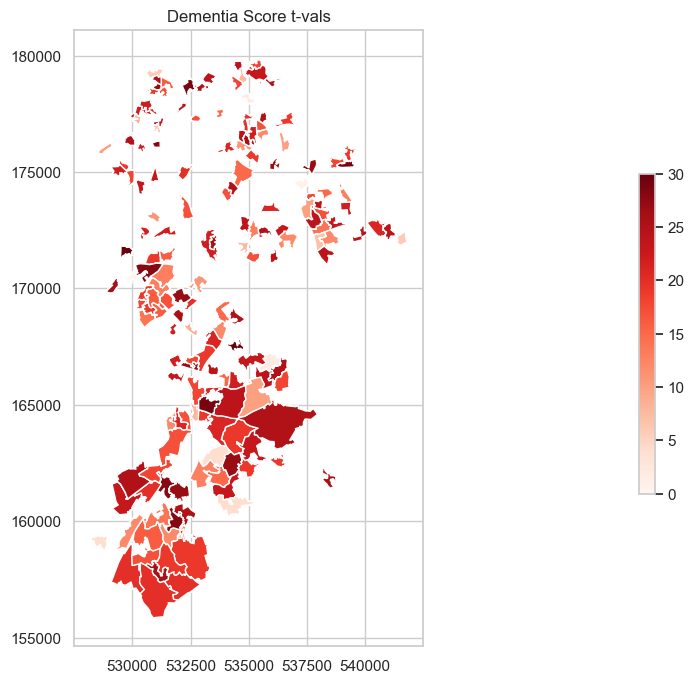

In [37]:
# GWR before
vmin, vmax = np.min(gdf['closest_mmse_NUMERATOR']), np.max(gdf['closest_mmse_NUMERATOR'])
ax = gdf.plot(column='closest_mmse_NUMERATOR', figsize=(8, 8), cmap='Reds', vmin=vmin, vmax=vmax)
ax.set_title('Dementia Score' + ' t-vals')

fig = ax.get_figure()
cax = fig.add_axes([1.0, 0.3, 0.02, 0.4]) # the position and size of colormap legend bar
sm_price = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Reds')
sm_price._A = []
fig.colorbar(sm_price, cax=cax, extend='neither')
plt.show()

In [38]:
# GWR
# standardize the variables
X_std = (X - X.mean(axis=0)) / X.std(axis=0)
y_std = (y - y.mean(axis=0)) / y.std(axis=0)

C:\Users\kayla\AppData\Local\Temp\ipykernel_17948\2487559361.py:3: RuntimeWarning: invalid value encountered in divide
  X_std = (X - X.mean(axis=0)) / X.std(axis=0)


In [39]:
#Coordinates for calibration points
def getXY(pt):
    return (pt.x, pt.y)

centroidseries = gdf['geometry'].centroid

u,v = [list(t) for t in zip(*map(getXY, centroidseries))]

coords = list(zip(u,v))

In [40]:
#Prepare dataset inputs
g_y = gdf['closest_mmse_NUMERATOR'].values.reshape((-1,1))
g_X = gdf['population_density'].values.reshape((-1,1))

g_coords = list(zip(u,v))

# Standardised our data to have mean of 0 and standard deviation of 1
g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)

g_y = g_y.reshape((-1,1))

g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [41]:
from mgwr.sel_bw import Sel_BW

# Select bandwidth for kernel
bw = Sel_BW(g_coords, 
            g_y,
            g_X,
            fixed=False,
            spherical=True)
# calculate the optimum bandwidth for local regression
bw.search(bw_min=2)

10215.0

In [42]:
from mgwr.gwr import GWR

model = GWR(coords, y, X, bw.bw[0])
results = model.fit()

d:\Anaconda\envs\mscui2023\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


d:\Anaconda\envs\mscui2023\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
d:\Anaconda\envs\mscui2023\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):
d:\Anaconda\envs\mscui2023\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


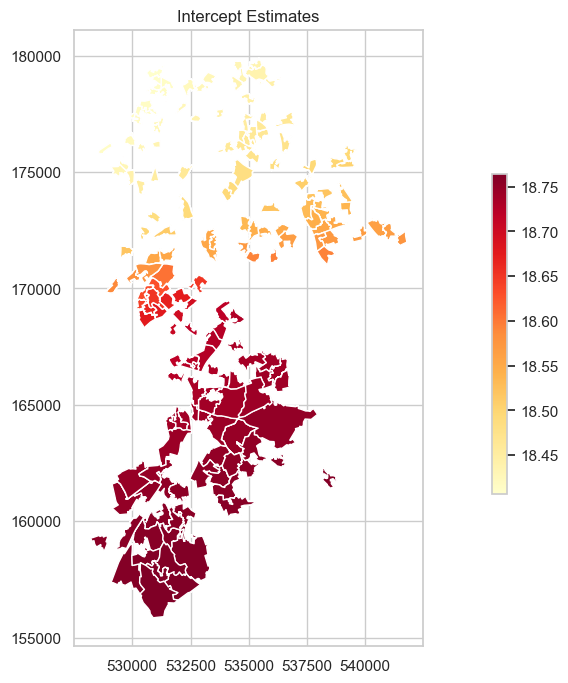

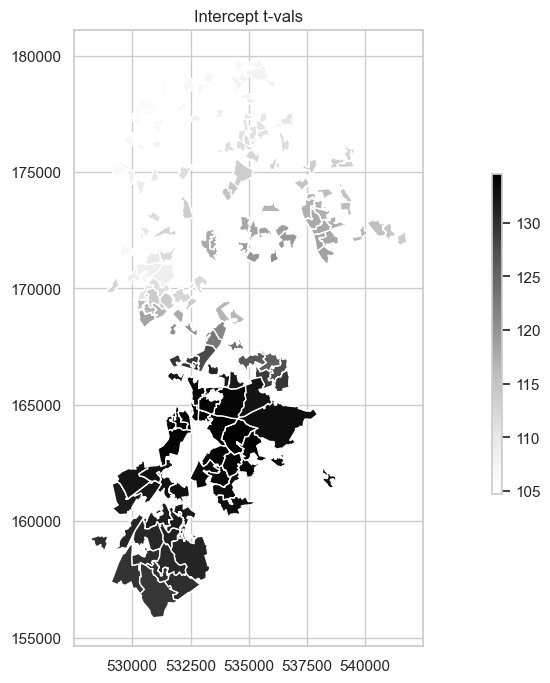

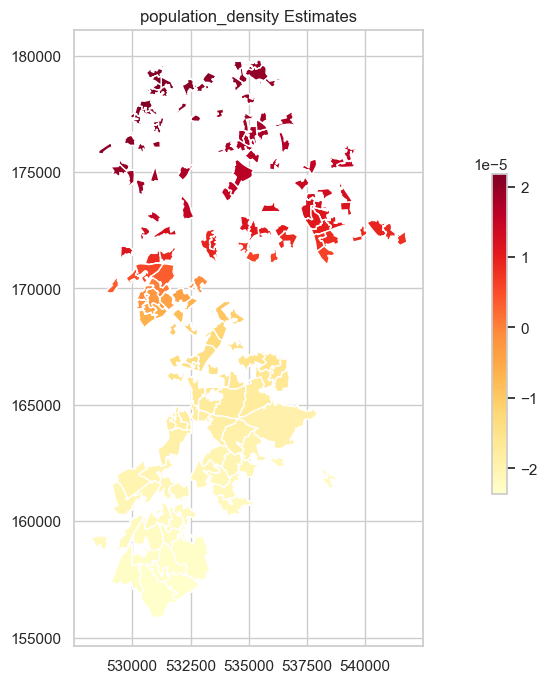

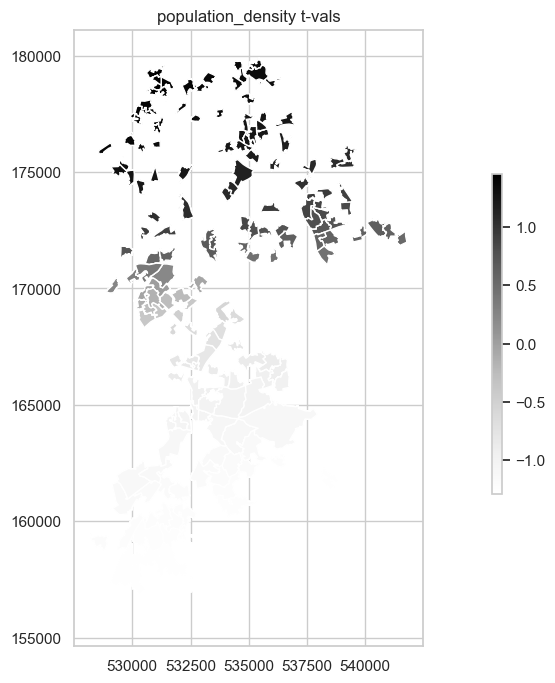

In [43]:
#Map Parameter estimates and T-vals for each covariate
labels = ['Intercept', 'population_density']
for param in range(results.params.shape[1]):
    gdf[str(param)] = results.params[:,param]
    vmin, vmax = np.min(gdf[str(param)]), np.max(gdf[str(param)]) 
    ax = gdf.plot(str(param), vmin=vmin, vmax=vmax, figsize=(5,8), cmap='YlOrRd')
    ax.set_title(labels[param] + ' Estimates')
    fig = ax.get_figure()
    cax = fig.add_axes([1.0, 0.3, 0.03, 0.4])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='YlOrRd')
    sm._A = []
    fig.colorbar(sm, cax=cax)
    
    gdf[str(param)] = results.tvalues[:,param]
    vmin, vmax = np.min(gdf[str(param)]), np.max(gdf[str(param)]) 
    ax = gdf.plot(str(param), vmin=vmin, vmax=vmax, figsize=(5,8), cmap='Greys')
    ax.set_title(labels[param] + ' t-vals')
    fig = ax.get_figure()
    cax = fig.add_axes([1.0, 0.3, 0.02, 0.4])
    sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='Greys')
    sm._A = []
    fig.colorbar(sm, cax=cax)

d:\Anaconda\envs\mscui2023\lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


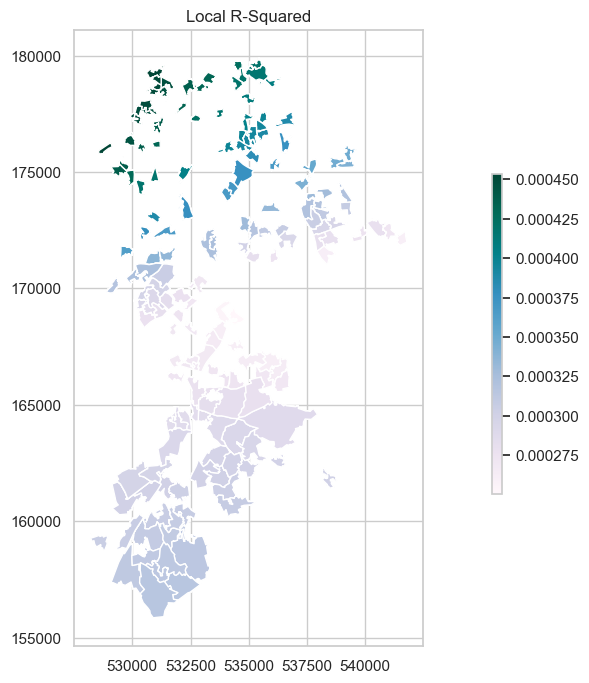

In [44]:
#Map local R-square values which is a weighted R-square at each observation location

gdf['localR2'] = results.localR2
vmin, vmax = np.min(gdf['localR2']), np.max(gdf['localR2']) 
ax = gdf.plot('localR2', vmin=vmin, vmax=vmax, figsize=(5,8), cmap='PuBuGn')
ax.set_title('Local R-Squared')
fig = ax.get_figure()
cax = fig.add_axes([1.0, 0.3, 0.02, 0.4])
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax), cmap='PuBuGn')
sm._A = []
fig.colorbar(sm, cax=cax)